In [20]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm

import matplotsoccer as mps
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
from utils import play_left_to_right, nice_time, plot_actions

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### La Liga 2015/16 데이터 로드

In [22]:
# StatsBomb 데이터 로더 객체 생성
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# La Liga 2015/16 시즌 선택
competitions = SBL.competitions()
laliga = competitions[
    (competitions.competition_name == "La Liga")
    & (competitions.season_name == "2015/2016")
]
laliga

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
43,27,11,La Liga,Spain,male,2015/2016


In [23]:
# 해당 시즌의 모든 경기 목록 로드
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in laliga.itertuples()
])
print(f"Total games: {len(games)}")
games.head()

Total games: 380


,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3825848,27,11,Regular Season,5,2015-09-23 20:00:00,221,322,2,2,Estadio Ciudad de Valencia,NaN
1,3825895,27,11,Regular Season,5,2015-09-23 22:00:00,208,213,2,0,Estadio de Gran Canaria,Carlos del Cerro Grande
2,3825894,27,11,Regular Season,36,2016-05-01 18:15:00,219,216,0,2,Estadio Abanca-Riazor,Carlos Clos Gómez
3,3825855,27,11,Regular Season,36,2016-05-02 20:30:00,223,221,3,1,Estadio La Rosaleda,Iñaki Bikandi Garrido
4,3825908,27,11,Regular Season,38,2016-05-15 19:00:00,214,322,4,2,RCDE Stadium,Mario Melero López


### SPADL 변환

In [ ]:
games_verbose = tqdm(list(games.itertuples()), desc="Loading game data")
df_teams, df_players, df_actions = [], [], []

for game in games_verbose:
    # Load data
    df_teams.append(SBL.teams(game.game_id))
    df_players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)

    # Convert to SPADL
    actions = spadl.statsbomb.convert_to_actions(
        events,
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )
    actions = play_left_to_right(actions, home_team_id=game.home_team_id)
    df_actions.append(actions)

# Concatenate all data
df_teams = pd.concat(df_teams).drop_duplicates(subset="team_id")
df_player_games = pd.concat(df_players).reset_index(drop=True) # 경기 별 선수 정보
df_players = pd.concat(df_players).drop_duplicates(subset="player_id") # 선수 정보
df_actions = pd.concat(df_actions).reset_index(drop=True)

Loading game data:   0%|          | 0/380 [00:00<?, ?it/s]

Data loading complete.


### xT Model 학습
La Liga 2015/16 시즌 데이터 모두 학습

In [60]:
# 학습 데이터 준비
A = df_actions.copy()
A["type_name"] = A.type_id.map(spadl.config.actiontypes_df().type_name.to_dict())
A["result_name"] = A.result_id.map(spadl.config.results_df().result_name.to_dict())
A["bodypart_name"] = A.bodypart_id.map(spadl.config.bodyparts_df().bodypart_name.to_dict())

# iterations:  39


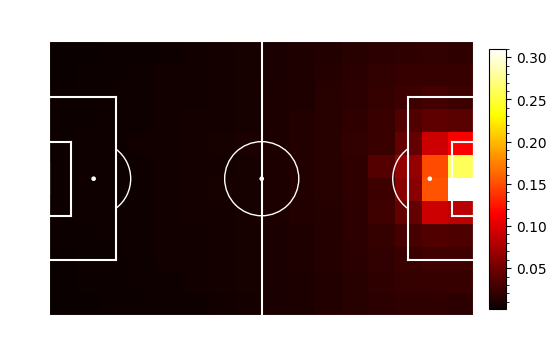

/tmp/ipykernel_15449/1394988894.py:15: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


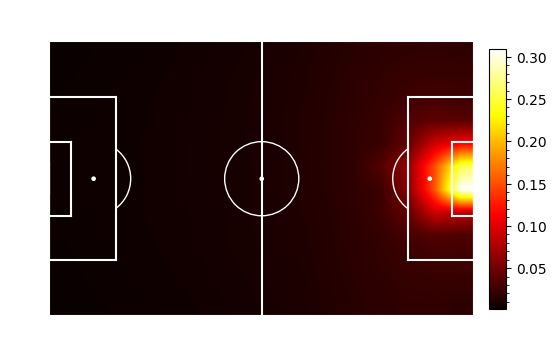

<Axes: >

In [61]:
# # 사전 학습된 xT 모델을 로드
# url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
# xTModel = xthreat.load_model(url_grid)

# xT model 학습 (16x12 grid)
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

# 학습 xT heatmap plot
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [59]:
# 성공한 move 액션의 xT 값 계산
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions['type_name'].value_counts()

type_name
dribble    295066
pass       246926
cross        2465
Name: count, dtype: int64

### Real Madrid xT 분석

In [49]:
# Real Madrid Team ID: 220
real_madrid_id = 220
real_madrid_team = df_teams[df_teams.team_id == real_madrid_id]
real_madrid_players = df_players[df_players.team_id == real_madrid_id]

# Real Madrid의 액션만 필터링
real_madrid_actions = df_actions[df_actions.team_id == real_madrid_id]

print(f"Real Madrid Actions: {len(real_madrid_actions)}")
real_madrid_team

Real Madrid Actions: 47926


,team_id,team_name
0,220,Real Madrid


In [50]:
# Real Madrid의 move 액션 필터링
real_madrid_mov_actions = mov_actions[mov_actions.team_id == real_madrid_id]

print(f"Total successful move actions: {len(mov_actions)}")
print(f"Real Madrid successful move actions: {len(real_madrid_mov_actions)}")
real_madrid_mov_actions.head()

Total successful move actions: 544457
Real Madrid successful move actions: 38250


,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT_value
17320,3825846,e5bfd725-fafe-4142-a0eb-acb51045e581,1,18.247,220,5463.0,45.9375,24.055,46.725,14.875,21,1,0,13,dribble,success,foot,-0.000446
17321,3825846,90845d0f-46ed-4505-8249-28eb7216bee8,1,22.292,220,5463.0,46.7250,14.875,49.175,10.115,0,1,5,14,pass,success,foot_right,0.000000
17322,3825846,dad0276c-d041-477c-96ca-1ac95a378d39,1,23.012,220,6399.0,49.1750,10.115,49.700,9.265,21,1,0,15,dribble,success,foot,0.000000
17323,3825846,83d2a12a-a67c-4b92-a986-dcdd18e7d281,1,23.360,220,6399.0,49.7000,9.265,55.125,11.985,0,1,4,16,pass,success,foot_left,0.002273
17324,3825846,62ab8d89-0e3f-4742-9b82-0fbeba5881dc,1,24.466,220,5463.0,54.8625,11.475,49.875,14.025,0,1,5,17,pass,success,foot_right,-0.002273


### 선수별 xT 기여도 평가 (Player Contribution Analysis)
선수별로 어떤 액션(Pass, Dribble, Shot)을 통해 xT를 창출했는지 분석하고, 90분당 기여도로 정규화하여 비교합니다.

In [57]:
# 1. 선수별, 액션 타입별 xT 합계 계산
player_xt = (
    real_madrid_mov_actions.groupby(["player_id", "type_name"])[["xT_value"]]
    .sum()
    .reset_index()
)

# Pivot table로 변환 (행: 선수, 열: 액션 타입)
player_xt_pivot = player_xt.pivot(index="player_id", columns="type_name", values="xT_value").fillna(0)
player_xt_pivot["total_xT"] = player_xt_pivot.sum(axis=1)

# 선수 이름 추가
player_xt_pivot["player_name"] = player_xt_pivot.index.map(df_players.set_index("player_id").player_name)

player_xt_pivot.sort_values("total_xT", ascending=False)

type_name,cross,dribble,pass,total_xT,player_name
player_id,,,,,
5552.0,2.026516,1.769173,4.641641,8.437330,Marcelo Vieira da Silva Júnior
6399.0,2.983686,1.621356,2.168747,6.773788,Gareth Frank Bale
5207.0,1.681553,4.108975,0.566005,6.356533,Cristiano Ronaldo dos Santos Aveiro
5463.0,0.521072,0.971460,4.632577,6.125108,Luka Modrić
5695.0,2.748550,0.579752,2.676738,6.005040,James David Rodríguez Rubio
4926.0,1.561090,2.251476,1.872956,5.685522,Francisco Román Alarcón Suárez
3063.0,2.073924,1.212933,1.923183,5.210040,Danilo Luiz da Silva
5574.0,0.302442,0.563853,4.334645,5.200940,Toni Kroos
5721.0,3.204421,0.512167,1.349410,5.065998,Daniel Carvajal Ramos


In [62]:
# 2. 출전 시간 계산 및 90분당 정규화 (Per 90)

# 선수별 총 출전 시간 계산
player_minutes = df_player_games[df_player_games.team_id == real_madrid_id].groupby("player_id")["minutes_played"].sum()

# xT 데이터와 출전 시간 병합
player_stats = player_xt_pivot.merge(player_minutes, left_index=True, right_index=True)

# 90분당 xT 계산
action_types = [col for col in player_stats.columns if col not in ["player_name", "minutes_played", "total_xT"]]
for col in action_types + ["total_xT"]:
    player_stats[f"{col}_per_90"] = player_stats[col] / player_stats["minutes_played"] * 90

# 최소 출전 시간 필터링
min_minutes = 900
top_players = player_stats[player_stats["minutes_played"] >= min_minutes].sort_values("total_xT_per_90", ascending=False)

top_players[["player_name", "minutes_played", "total_xT_per_90"] + [f"{col}_per_90" for col in action_types]].head(10)

,player_name,minutes_played,total_xT_per_90,cross_per_90,dribble_per_90,pass_per_90
player_id,,,,,,
5695.0,James David Rodríguez Rubio,1568,0.344677,0.157761,0.033277,0.153639
6399.0,Gareth Frank Bale,1784,0.341727,0.150522,0.081795,0.109410
5552.0,Marcelo Vieira da Silva Júnior,2564,0.296162,0.071134,0.062100,0.162928
4926.0,Francisco Román Alarcón Suárez,1881,0.272035,0.074693,0.107726,0.089615
5721.0,Daniel Carvajal Ramos,1685,0.270587,0.171156,0.027356,0.072075
5200.0,Lucas Vázquez Iglesias,1300,0.228412,0.078608,0.090121,0.059683
3063.0,Danilo Luiz da Silva,2115,0.221704,0.088252,0.051614,0.081838
5463.0,Luka Modrić,2689,0.205005,0.017440,0.032514,0.155051
5456.0,Mateo Kovačić,1095,0.175125,0.005764,0.080856,0.088505


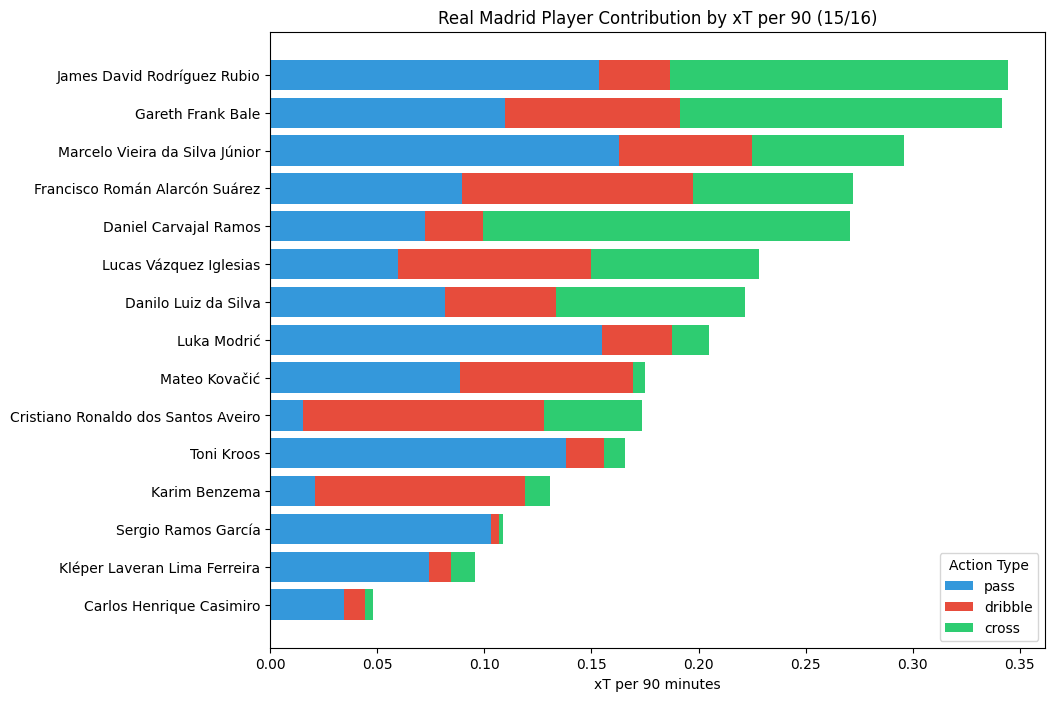

In [63]:
# 3. 시각화: Stacked Bar Chart (Top 15 Players by xT per 90)

top_15 = top_players.head(15).sort_values("total_xT_per_90", ascending=True) # 차트에서는 아래에서 위로 그리므로 오름차순 정렬

fig, ax = plt.subplots(figsize=(10, 8))

bottom = np.zeros(len(top_15))
colors = {"pass": "#3498db", "dribble": "#e74c3c", "cross": "#2ecc71", "shot": "#f1c40f"}

for action in ["pass", "dribble", "cross", "shot"]:
    if f"{action}_per_90" in top_15.columns:
        values = top_15[f"{action}_per_90"].values
        ax.barh(top_15["player_name"], values, left=bottom, label=action, color=colors.get(action, "gray"))
        bottom += values

ax.set_xlabel("xT per 90 minutes")
ax.set_title("Real Madrid Player Contribution by xT per 90 (15/16)")
ax.legend(title="Action Type")
plt.show()

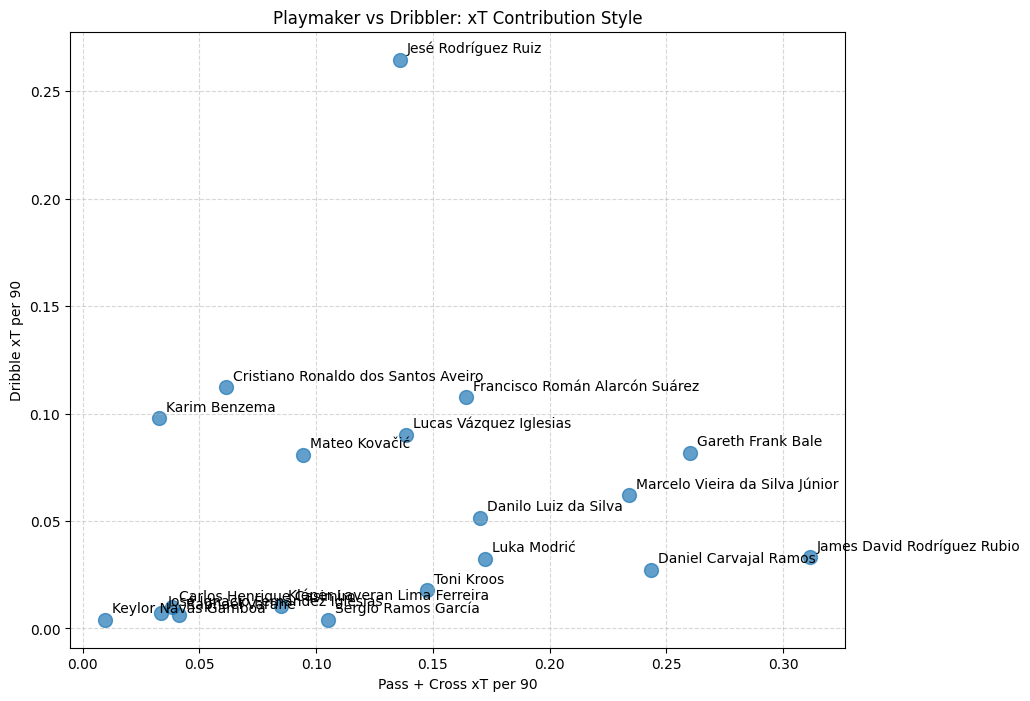

In [54]:
# 4. 시각화: Scatter Plot (Passing xT vs Carrying xT)

fig, ax = plt.subplots(figsize=(10, 8))

# x축: Pass + Cross xT, y축: Dribble xT
x_col = "pass_per_90"
y_col = "dribble_per_90"

# Cross가 있다면 Pass에 합산하여 'Passing Threat'으로 간주
if "cross_per_90" in top_players.columns:
    x_values = top_players["pass_per_90"] + top_players["cross_per_90"]
    x_label = "Pass + Cross xT per 90"
else:
    x_values = top_players["pass_per_90"]
    x_label = "Pass xT per 90"

y_values = top_players["dribble_per_90"]
y_label = "Dribble xT per 90"

ax.scatter(x_values, y_values, alpha=0.7, s=100)

# 선수 이름 라벨링
for i, txt in enumerate(top_players["player_name"]):
    ax.annotate(txt, (x_values.iloc[i], y_values.iloc[i]), xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Playmaker vs Dribbler: xT Contribution Style")
ax.grid(True, linestyle="--", alpha=0.5)

plt.show()

### 경기/팀별 전술 분석 (Match & Tactical Analysis)
1. **xT Flow Chart**: 주요 경기(El Clásico)에서의 시간대별 xT 흐름을 시각화하여 경기 주도권을 분석합니다.
2. **Spatial Heatmap**: Real Madrid가 경기장의 어느 구역에서 위협을 창출하는지 분석합니다.

Analyzing Match: 2016-04-02 20:30:00 | Barcelona 1 - 2 Real Madrid


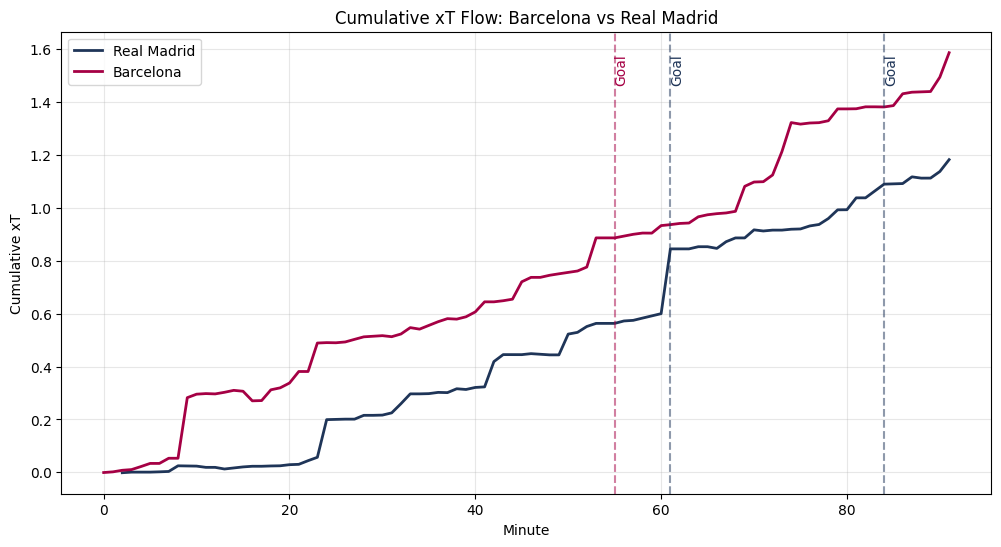

In [55]:
# 1. Match Analysis: El Clásico (Real Madrid vs Barcelona)

# Barcelona Team ID 찾기
barca_id = df_teams[df_teams.team_name == "Barcelona"].team_id.values[0]

# 엘 클라시코 경기 찾기 (홈 또는 어웨이)
el_clasico_games = games[
    ((games.home_team_id == real_madrid_id) & (games.away_team_id == barca_id)) |
    ((games.home_team_id == barca_id) & (games.away_team_id == real_madrid_id))
]

# 첫 번째 엘 클라시코 경기 선택
target_game_id = el_clasico_games.iloc[0].game_id
target_game = games[games.game_id == target_game_id].iloc[0]

home_team_name = df_teams[df_teams.team_id == target_game.home_team_id].team_name.values[0]
away_team_name = df_teams[df_teams.team_id == target_game.away_team_id].team_name.values[0]

print(f"Analyzing Match: {target_game.game_date} | {home_team_name} {target_game.home_score} - {target_game.away_score} {away_team_name}")

# xT 값을 전체 데이터프레임 A에 매핑 (mov_actions의 인덱스 활용)
A["xT_value"] = 0
A.loc[mov_actions.index, "xT_value"] = mov_actions["xT_value"]

# 해당 경기의 액션 데이터 가져오기
match_actions = A[A.game_id == target_game_id].copy()

# 시간대별 누적 xT 계산
match_actions["minute"] = (match_actions.period_id - 1) * 45 + match_actions.time_seconds // 60
match_actions = match_actions.sort_values(["period_id", "time_seconds"])

# 팀별 누적 xT (Rolling Sum으로 흐름 파악 - 5분 윈도우)
# 여기서는 단순 누적(Cumulative Sum)으로 전체 흐름을 봅니다.
rm_xt_cum = match_actions[match_actions.team_id == real_madrid_id].groupby("minute")["xT_value"].sum().cumsum()
barca_xt_cum = match_actions[match_actions.team_id == barca_id].groupby("minute")["xT_value"].sum().cumsum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(rm_xt_cum.index, rm_xt_cum.values, label="Real Madrid", color="#1F3558", linewidth=2)
plt.plot(barca_xt_cum.index, barca_xt_cum.values, label="Barcelona", color="#A50044", linewidth=2)

# 골 들어간 시점 표시 (Optional)
goals = match_actions[match_actions.type_name == "shot"]
goals = goals[goals.result_name == "success"]
for _, goal in goals.iterrows():
    team_color = "#1F3558" if goal.team_id == real_madrid_id else "#A50044"
    plt.axvline(x=goal.minute, color=team_color, linestyle="--", alpha=0.5)
    plt.text(goal.minute, plt.ylim()[1]*0.95, "Goal", color=team_color, rotation=90, verticalalignment='top')

plt.title(f"Cumulative xT Flow: {home_team_name} vs {away_team_name}")
plt.xlabel("Minute")
plt.ylabel("Cumulative xT")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

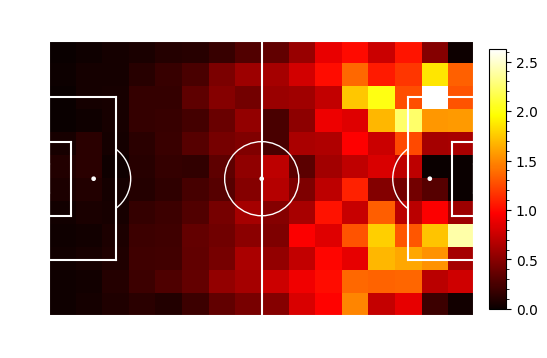

<Axes: >

In [ ]:
# 2. Spatial xT Heatmap

# Real Madrid의 xT 발생 위치 (x, y)
rm_xT_actions = real_madrid_mov_actions[real_madrid_mov_actions.xT_value > 0]

# Binning xT values into grid cells (16x12 grid)
x_bins = np.linspace(0, 105, 17)
y_bins = np.linspace(0, 68, 13)

# 2D Histogram of xT sum
xt_matrix, _, _ = np.histogram2d(
    rm_xT_actions.start_x,
    rm_xT_actions.start_y,
    bins=[x_bins, y_bins],
    weights=rm_xT_actions.xT_value
)

# Visualize
mps.heatmap(xt_matrix.T, cmap="hot", linecolor="white", cbar="True")